# Klasifikacija teksta

U ovoj svesci proći ćemo ponovo kroz primer koji smo uveli u priči o konvolutivnim neuronskim mrežama. Bavićemo se klasifikacijom IMDB filmskih pregleda na pozitivne i negativne, ali ovoga puta uz korišćenje rekurentnih neuronskih mreža. 

In [1]:
import torch
import numpy as np

SEED = 7
# za determinističko izvršavanje sveske:
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Priprema skupa podataka

Proći ćemo kroz korake obrade teksta korišćenjem originalnih tekstualnih sadržaja recenzija koje se mogu preuzeti sa [ove](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) adrese. 

In [2]:
max_features = 2000 

In [3]:
import pandas as pd

In [4]:
reviews = pd.read_csv('data/IMDB.csv')

U pročitanom skupu se nalaze svi pregledi koje treba dalje razvrstati na skupove za treniranje, validaciju i testiranje.

In [5]:
reviews.shape

(50000, 2)

In [6]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Pozitivni sentiment ćemo mapirati u vrednost 1, a negativni u vrednost 0.

In [7]:
reviews['target'] = reviews['sentiment'].apply(lambda s: 1 if s=='positive' else 0)

In [8]:
reviews['target'].value_counts()

target
1    25000
0    25000
Name: count, dtype: int64

Zbog dalje obrade teksta, pročitaćemo i jedan originalni pregled.

In [9]:
demo_review = reviews['review'][0]

In [10]:
demo_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Iz ovako pročitanih dokumenata možemo izbrisati zaostale HTML etikete i zameniti višestruke beline jednostrukim. Takođe, možemo sve zapisati malim slovima.

In [11]:
import re
def prepare_review(review):
    clean_review = re.sub('<.+?>', ' ', review)
    clean_review = re.sub('\s+', ' ', clean_review)
    return clean_review.lower()
prepare_review(demo_review)

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows

Ovako napisanu funkciju ćemo dalje primeniti nad svakim pregledom.

In [12]:
reviews['prepared_review'] = reviews['review'].apply(lambda r: prepare_review(r))

Dalje, da bismo izdvojili skup za treniranje, skup za validaciju i skup za testiranje, promešaćemo indekse skupova podataka - podrazumevano prvo imamo sve pozitivne preglede uzastopno, a zatim i sve negativne.

In [13]:
indices = np.arange(reviews.shape[0])
np.random.shuffle(indices)

U test skup ćemo smestiti polovinu pregleda, a ostale ćemo podeliti na preglede za traniranje i validaciju.

In [14]:
number_of_reviews = reviews.shape[0]
test_reviews = reviews.iloc[indices[number_of_reviews//2:]]
validation_size = int(0.2*number_of_reviews)
train_reviews = reviews.iloc[indices[0:number_of_reviews//2-validation_size]]
validation_reviews = reviews.iloc[indices[number_of_reviews//2-validation_size:number_of_reviews//2]]

In [15]:
print('train reviews', train_reviews.shape)
print('validation reviews', validation_reviews.shape)
print('test reviews', test_reviews.shape)

train reviews (15000, 4)
validation reviews (10000, 4)
test reviews (25000, 4)


Za podelu teksta na tokene koristićemo Tokenizer iz biblioteke `torchtext`.

In [1]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer('basic_english')

Iz tekstova ćemo izbaciti znakove interpukcije i prebrojaćemo broj pojavljivanje svakog tokena.

In [17]:
from collections import Counter
import string

counter = Counter()
for line in train_reviews['prepared_review']:
    counter.update(filter(lambda x: x not in string.punctuation, tokenizer(line)))
len(counter)

78258

Dobili smo 78258 tokena. Od njih ćemo napraviti rečnik sa tokenima koji se pojavljuju barem 50 puta.

In [18]:
from collections import OrderedDict

from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True) # sortiramo tokene po frekvenciji
ordered_dict = OrderedDict(sorted_by_freq_tuples)
recnik = vocab(ordered_dict, specials=['<unk>', '<pad>'], min_freq=50) # pravimo vocabular sa tokenima koji se pojavljuju barem 300 puta
recnik.set_default_index(recnik['<unk>'])
print("Indeks reci 'the':", recnik['the'])
print("Rec na indeksu 10:", recnik.get_itos()[10])

Indeks reci 'the': 2
Rec na indeksu 10: i


In [19]:
print(f'U recniku je preostalo {len(recnik)} reci')

U recniku je preostalo 4856 reci


Na osnovu rečnika napravićemo klasu koja će transformisati rečenicu u tenzor indeksa. Svaku recenziju ćemo skratiti, ili po potrebi produžiti do dužine od 500 tokena.

In [20]:
import torch.nn as nn
import torchtext.transforms as transforms

class Tokenizer(nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer

    def forward(self, text):
        return self.tokenizer(text)
    
class RemovePunctuation(nn.Module):
    def forward(self, token_list):
        return [token for token in token_list if token not in string.punctuation]

seqence_len = 500

text_transformation = transforms.Sequential(
    Tokenizer(tokenizer),
    RemovePunctuation(),
    transforms.VocabTransform(recnik),
    transforms.Truncate(seqence_len),
    transforms.ToTensor(padding_value=recnik['<pad>']),
    transforms.PadTransform(seqence_len, pad_value=recnik['<pad>']),
)

In [21]:
text_transformation("Good movie!")

tensor([50, 16,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1, 

Korišćenjem dobijene transformacije možemo pretvoriti skupove podataka u torch tenzore.

In [22]:
X_train = torch.stack(
    [text_transformation(review) for review in train_reviews['prepared_review']]
)
y_train = torch.tensor(train_reviews['target'].to_numpy())

X_valid = torch.stack(
    [text_transformation(review) for review in validation_reviews['prepared_review']]
)
y_valid = torch.tensor(validation_reviews['target'].to_numpy())

X_test = torch.stack(
    [text_transformation(review) for review in test_reviews['prepared_review']]
)
y_test = torch.tensor(test_reviews['target'].to_numpy())


In [23]:
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


Nadalje ćemo eksperimentisati sa različitim rekurentnim arhitekturama. Mreže koje ćemo konstruisati će biti plitke i trenirane u malom broju epoha tako da se za vežbu predlaže istraživanje ponašanja mreže sa većim brojem epoha, dodatnim regularizacijama i manjim koracima učenja. Takođe, mogu se varirati veličina ugnježđene reprezentacije koju dobijamo `Embedding` soljem, kao i velilčina izlaza.

In [ ]:
from tqdm import tqdm
from collections import defaultdict
import torch
import torch.nn as nn

def evaluate_model(model, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    test_loss = 0
    test_accuracy = 0
    test_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='test batch', leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
        
            batch_size = labels.size(0)
            labels = labels.to(torch.float32)
    
            predictions = model(inputs).squeeze()
            
            loss = nn.functional.binary_cross_entropy(predictions, labels)
            accuracy = ((predictions > 0.5) == labels).float().mean()
            test_loss += loss.item() * batch_size
            test_accuracy += accuracy.item() * batch_size
            test_samples += batch_size 
    test_loss /= test_samples
    test_accuracy /= test_samples

    return test_loss, test_accuracy

def train_model(model, optimizer, train_loader, valid_loader, epochs=5):    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'train_steps': [],
        'valid_loss': [],
        'valid_accuracy': [],
        'valid_steps': [],
    }
    
    training_step = 0
    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
    
            batch_size = labels.size(0)
            labels = labels.to(torch.float32)
            
            predictions = model(inputs).squeeze()
            loss = nn.functional.binary_cross_entropy(predictions, labels)
            accuracy = ((predictions > 0.5) == labels).float().mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            metrics['train_loss'].append(loss.item())
            metrics['train_accuracy'].append(accuracy.item())
            metrics['train_steps'].append(training_step)
            training_step += 1
            
        # Validation phase
        model.eval()
        with torch.no_grad():
            valid_accuracy = 0
            valid_loss = 0
            valid_samples = 0
            for inputs, labels in tqdm(valid_loader):
                inputs, labels = inputs.to(device), labels.to(device)
            
                batch_size = labels.size(0)
                labels = labels.to(torch.float32)
    
                predictions = model(inputs).squeeze()
                
                loss = nn.functional.binary_cross_entropy(predictions, labels, reduction='sum')
                correct = ((predictions > 0.5) == labels).float().sum()
                valid_accuracy += correct.item()
                valid_loss += loss.item()
                valid_samples += batch_size

            valid_loss /= valid_samples
            valid_accuracy /= valid_samples
            metrics['valid_loss'].append(valid_loss)
            metrics['valid_accuracy'].append(valid_accuracy)
            metrics['valid_steps'].append(training_step)
        
    return metrics


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(metrics):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_steps'], metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_steps'], metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_steps'], metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(metrics['val_steps'], metrics['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Jednostavna rekurentne neuronska mreža

In [26]:
embedding_size = 32
output_size = 128

In [27]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, embedding_size, num_tokens, hidden_size):
        super().__init__()

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

        nn.init.xavier_uniform_(self.embedding.weight)
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.linear.weight)
    
    def forward(self, x):
        x = self.embedding(x)
        outputs, h_n = self.rnn(x)
        x = outputs[:, -1, :]
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [28]:
len(recnik)

4856

In [29]:
model_simple = SimpleRNN(embedding_size, len(recnik), output_size)

In [ ]:
from torch.optim import Adam
optimizer = Adam(params=model_simple.parameters(), lr=3e-4)
metrics_simple = train_model(model_simple, optimizer, train_loader, valid_loader, epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

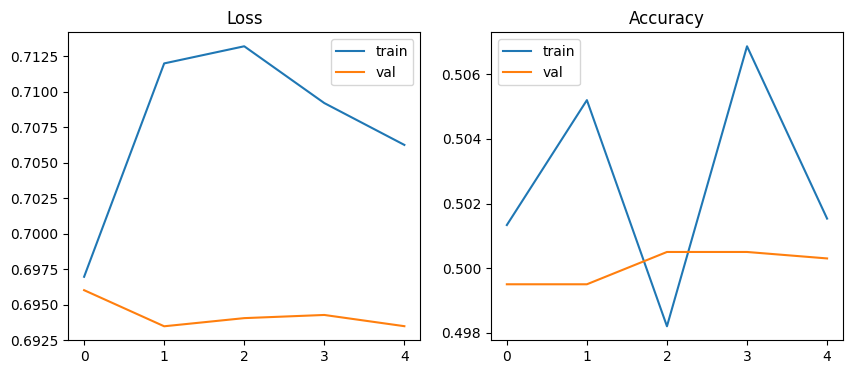

In [31]:
plot_graphs(metrics_simple)

In [32]:
loss_simple, accuracy_simple  = evaluate_model(model_simple, test_loader)

test batch:   0%|          | 0/196 [00:00<?, ?it/s]

In [33]:
print('Loss: ', loss_simple)

Loss:  0.693407816696167


In [34]:
print('Accuracy: ', accuracy_simple)

Accuracy:  0.5011999999904633


Podsetimo se, za čuvanje modela može da se iskoristi funkcija `torch.save`.

In [35]:
# torch.save(simple_model, "models/RNN.pth")

### LSTM rekurentna neuronska mreža 

In [36]:
embedding_dimensionality = 32
units = 128

In [37]:
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, embedding_size, num_tokens, hidden_size):
        super().__init__()
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.dropout = nn.Dropout(0.2) 
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, x):
        x = self.embedding(x)
        x, (h_n, c_n) = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


In [38]:
model_lstm = SimpleLSTM(embedding_size, len(recnik), output_size)
model_lstm

SimpleLSTM(
  (embedding): Embedding(4856, 32)
  (lstm): LSTM(32, 128)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = Adam(params=model_lstm.parameters(), lr=0.001)
metrics_lstm = train_model(model_lstm, optimizer, train_loader, valid_loader, epochs=3)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

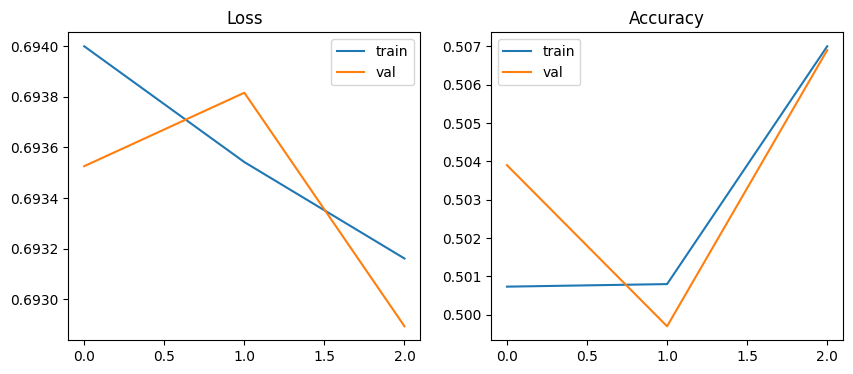

In [40]:
plot_graphs(metrics_lstm)

In [41]:
loss_lstm, accuracy_lstm = evaluate_model(model_lstm, test_loader)

test batch:   0%|          | 0/196 [00:00<?, ?it/s]

In [42]:
print('Loss: ', loss_lstm)

Loss:  0.693107043800354


In [43]:
print('Accuracy: ', accuracy_lstm)

Accuracy:  0.50568


In [44]:
# torch.save(simple_model, "models/LSTM.pth")

### Stekovana LSTM mreže

In [45]:
embedding_dimensionality = 32
units = 128

In [46]:
import torch.nn as nn

class StackedLSTM(nn.Module):
    def __init__(self,embedding_size, num_tokens, hidden_size, num_layers):
        super().__init__()

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        # Using num_layers to create a stacked LSTM
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)  # Assuming you want a dropout rate of 0.2
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get the last sequence output
        x = self.dropout(x)  # Apply dropout
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


In [47]:
model_stacked_lstm = StackedLSTM(embedding_size, len(recnik), output_size, 2)
model_stacked_lstm

StackedLSTM(
  (embedding): Embedding(4856, 32)
  (lstm): LSTM(32, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = Adam(params=model_stacked_lstm.parameters(), lr=0.001)
metrics_stacked_lstm = train_model(model_stacked_lstm, optimizer, train_loader, valid_loader, epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

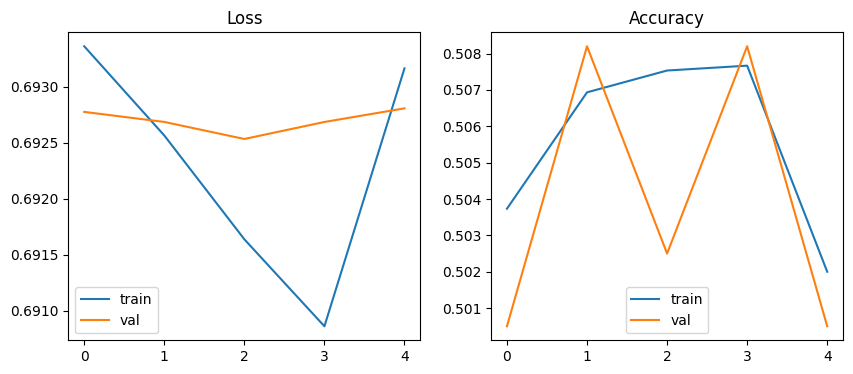

In [49]:
plot_graphs(metrics_stacked_lstm)

In [50]:
torch.save(model_stacked_lstm.state_dict(), 'models/LSTM_stacked.pth')

### GRU rekurentna neuronska mreža 

In [51]:
embedding_dimensionality = 32
units = 128

In [52]:
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, embedding_size, num_tokens, hidden_size):
        super(GRUNet, self).__init__()

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)  # Assuming you want a dropout rate of 0.2
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Get the last sequence output
        x = self.dropout(x)  # Apply dropout
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


In [53]:
model_gru = GRUNet(embedding_size, len(recnik), output_size)
model_gru

GRUNet(
  (embedding): Embedding(4856, 32)
  (gru): GRU(32, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = Adam(params=model_gru.parameters(), lr=0.001)
metrics_gru = train_model(model_gru, optimizer, train_loader, valid_loader, epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

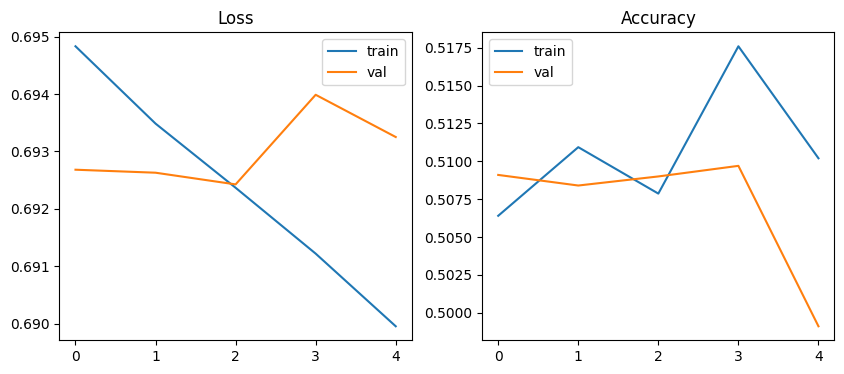

In [55]:
plot_graphs(metrics_gru)

In [56]:
torch.save(model_gru.state_dict(), 'models/GRU.pth')

### Neuronska mreža sa pritreniranim ugnježđavanjima

Isprobaćemo i varijantu mreže koja će koristiti pritrenirane ugnježđene reprezentacije. Ovakve reprezentacije se obično uče nad većim skupom podataka i mogu biti korisne za mnoge zadatke u kojima je raspoloživi skup mnogo manjeg obima. O načinima njihovog učenja biće više reči u sekciji o nenadgledanom mašinskom učenju, a ove ćemo iskoristiti `GloVe` reprezentacije. Ceo paket sa reprezentacijama reči različitih dužina (50, 100, 200 i 300) ukupne veličine 822MB se može preuzeti sa [zvanične adrese](https://nlp.stanford.edu/projects/glove/) Stanford grupe. Mi ćemo u radu koristiti reprezentacije dužine 100 koje se nalaze u datoteci `glove.6B.100d.txt` (347.1MB) koja se može preuzeti pojedinačno npr. sa [ove](https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt) adrese. 

Prvo ćemo pročitati iz preuzete datoteke sve podržane reči i njihove vektorske reprezentacije. U pojedinačnim redovima datoteke se prvo nalazi reči, a potom 100 realnih vrednosti koje predstavljaju njenu vektorsku reprezentaciju.

In [57]:
word_embeddings = {}
with open('data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

In [58]:
len(word_embeddings)

400000

Na primer, vektorska reprezentacija reči `movie` se može dobiti sa:

In [59]:
word_embeddings['movie']

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

Prilikom učenja ovakvih reprezentacija obično se ne vrši priprema teksta na način koji smo opisivali u generisanju `Tf-Idf` reprezentacija (normalizacija, stemiranje, lematizacija) kako bi mreža mogla da nauči različite aspekte pojedinačnih reči. Tako za imenicu movie postoji i reprezentacija reči movies, a za glagol play i reprezentacije za plays, playing i played.

In [60]:
embedding_dimensionality = 100
number_of_words = len(recnik)
embedding_matrix = np.zeros((number_of_words, embedding_dimensionality))

In [61]:
for word, i in recnik.get_stoi().items():
    if i >= max_features:
        break
    embedding_vector = word_embeddings.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
    # ukoliko rec teksta nema GloVe reprezentaciju, njoj ce odgovarati vektor nula

In [62]:
embedding_matrix.shape

(4856, 100)

Ostalo je još da kreiramo i naučimo model koji koiristi matricu ugnježdavanja. Prilikom zadavanja Embedding sloja ovoga puta ćemo preko parametra `weight` zadati koje vrednosti treba koristiti, a kako ovaj sloj ne treba menjati u toku učenja, postavićemo i `require_grad` na `False`.

In [63]:
import torch.nn as nn

class GloveNet(nn.Module):
    def __init__(self, seqence_len, hidden_size, pretrained_weigths):
        super().__init__()
        num_tokens, embedding_dim = pretrained_weigths.shape
        pretrained_weigths = nn.Parameter(torch.tensor(pretrained_weigths, dtype=torch.float))
        self.embedding = nn.Embedding(num_tokens, embedding_dim)
        self.embedding.requires_grad_(False)
        self.embedding.weight = pretrained_weigths
        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(embedding_dim * seqence_len, hidden_size)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        bs, seq_len = x.shape
        x = self.embedding(x)
        x = x.reshape(bs, -1)
        x = self.dropout1(x)  # Apply dropout
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x


In [64]:
model_glove = GloveNet(500, 32, embedding_matrix)
model_glove

GloveNet(
  (embedding): Embedding(4856, 100)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=50000, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = Adam(params=model_glove.parameters(), lr=0.001)
metrics_glove = train_model(model_glove, optimizer, train_loader, valid_loader, epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

Train batches:   0%|          | 0/118 [00:00<?, ?it/s]

Valid batches:   0%|          | 0/79 [00:00<?, ?it/s]

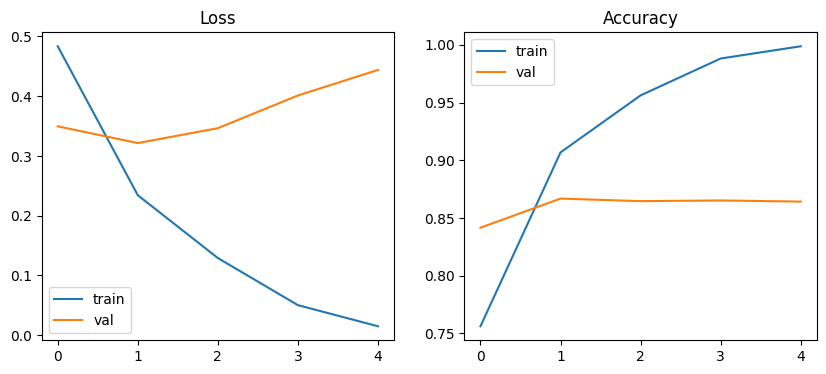

In [66]:
plot_graphs(metrics_glove)

In [67]:
loss_with_glove, accuracy_with_glove = evaluate_model(model_glove, test_loader)

test batch:   0%|          | 0/196 [00:00<?, ?it/s]

In [68]:
print('Loss: ', loss_with_glove)

Loss:  0.4455462575817108


In [69]:
print('Accuracy: ', accuracy_with_glove)

Accuracy:  0.8671599999809265


In [70]:
torch.save(model_glove.state_dict(), 'models/glove.pth')

### Zadaci: 
- Ispitati ponašanje mreža koje se duže treniraju. 
- Ispitati tok treniranja kada se koriste manji koraci učenja i nešto drugačija veličina paketića.